In [7]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
# Rotation
from scipy.spatial.transform import Rotation as R

import rclpy
from rclpy.node import Node


# Odometry
from nav_msgs.msg import Odometry

from geometry_msgs.msg import Twist

# Tf2
from tf2_ros import TransformException
from tf2_ros.buffer import Buffer
from tf2_ros.transform_listener import TransformListener

import pickle
import glob
import os
from PyQt5.QtWidgets import QFileDialog, QWidget, QApplication
from scipy.interpolate import CubicSpline, Rbf


# Load pickle file
QApp = QApplication([])
QWidget = QWidget()
# open dialog to select file



In [8]:

def get_odom_data(dict, dict_key):
	orientations = []
	positions = []
	velocities = []
	ang_velocities = []
	timesteps = []
	for msg in dict[dict_key]:
		orientations.append(R.from_quat([msg.pose.pose.orientation.x, msg.pose.pose.orientation.y, msg.pose.pose.orientation.z, msg.pose.pose.orientation.w]))
		positions.append(np.array([msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.position.z]))
		velocities.append(np.array([msg.twist.twist.linear.x, msg.twist.twist.linear.y, msg.twist.twist.linear.z]))
		ang_velocities.append(np.array([msg.twist.twist.angular.x, msg.twist.twist.angular.y, msg.twist.twist.angular.z]))
		timesteps.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)

	odom_dict = {"orientations" : orientations, "positions" : positions, "velocities" : velocities, "ang_velocities" : ang_velocities, "timesteps" : timesteps}
	return odom_dict

def get_twist_data(dict, dict_key):
	linear = []
	angular = []
	for msg in dict[dict_key]:
		linear.append(np.array([msg.linear.x, msg.linear.y, msg.linear.z]))
		angular.append(np.array([msg.angular.x, msg.angular.y, msg.angular.z]))
	twist_dict = {"linear" : linear, "angular" : angular}
	return twist_dict

def get_joint_states(dict, dict_key):
	names = []
	positions = []
	velocities = []
	efforts = []
	timesteps = []
	for msg in dict[dict_key]:
		names.append(msg.name)
		positions.append(np.array(msg.position))
		velocities.append(np.array(msg.velocity))
		efforts.append(np.array(msg.effort))
		timesteps.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)

	joint_states_dict = {"name" : names, "positions" : positions, "velocities" : velocities, "efforts" : efforts, "timesteps" : timesteps}
	return joint_states_dict

def get_localization_data(file_path):

	with open(file_path, "rb") as f:
		data = pickle.load(f)

	positions = data[:][0]
	orientations = data[:][1]
	timesteps = data[:][2]


	localization_dict = {"orientations" : orientations, "positions" : positions, "timesteps" : timesteps}
	return localization_dict


def get_pose_array(dict, dict_key):
	plan = np.array([[pose.position.x, pose.position.y, pose.position.z] for pose in dict[dict_key].poses])
	return plan



In [9]:

def interpolate_points(points, num_points):
            
    # Concatenate the points to form a 3x3 array
    # points = np.array([p1, p2, p3])

    # Calculate the distances between each pair of points
    distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))

    # Calculate the cumulative distance along the curve
    cumulative_distances = np.cumsum(distances)
    cumulative_distances = np.insert(cumulative_distances, 0, 0) # Add initial distance of 0

    # Create a cubic spline interpolation of the points
    interp = CubicSpline(cumulative_distances, points, bc_type='not-a-knot')

    # Generate points along the curve at the specified resolution
    s_vals = np.linspace(cumulative_distances[0], cumulative_distances[-1], num_points)

    # for idx, dist in enumerate(cumulative_distances[:-1], ):
    #     num_points = int(np.ceil((cumulative_distances[idx + 1] - dist)/resolution))
    #     # print(num_points)
    #     s_val = np.linspace(dist, cumulative_distances[idx + 1], num_points)
    #     s_vals = np.append(s_vals, s_val[1:])

    # Generate 10 points along the curve
    interp_points = interp(s_vals)

    return interp_points


In [10]:
file_path = QFileDialog.getOpenFileName(QWidget, 'Open file', '/home/daniel/Documents/master/rosbags/pose_data')[0]
print(file_path)

with open(file_path, "rb") as f:
    data = pickle.load(f)
%matplotlib inline

/home/daniel/Documents/master/rosbags/pose_data/island_boy.pkl


In [12]:
rear_link_dict = get_odom_data(data, "rear_link_pose_gt")
base_link_dict = get_odom_data(data, "base_link_pose_gt")
waypoints = get_pose_array(data, "wayposes")
plan = get_pose_array(data, "global_pln")
cmd_vel = get_twist_data(data, "cmd_vel")
joint_states = get_joint_states(data, "joint_state_controller")
try:
    odometry_ekf = get_odom_data(data, "odometry_ekf")
except:
    print("No ekf data")
    odometry_ekf = None
    pass

No ekf data


AttributeError: 'Figure' object has no property 'projection'

(55, 3)


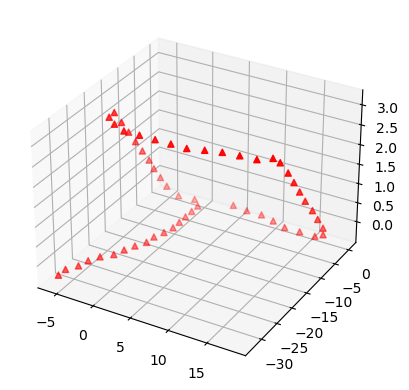

In [24]:

#ax.scatter(points[:,0], points[:,1], points[:,2], c='b', marker='^')
print(plan.shape)
fig = plt.figure()

fig.canvas.toolbar_visible = True


ax = fig.add_subplot(111, projection='3d')

ax.scatter(plan[:,0], plan[:,1], plan[:,2], c='r', marker='^')

# ax.set_box_aspect((np.ptp(plan[:,0]), np.ptp(plan[:,1]), np.ptp(plan[:,2])))  # aspect ratio is 1:1:1 in data space

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# display(fig.canvas)
# fig, ax = poly_fit_plot(points, fig)
# scatter_plot(plan, waypoints)

In [28]:

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas



AttributeError: 'FigureCanvasAgg' object has no attribute 'layout'

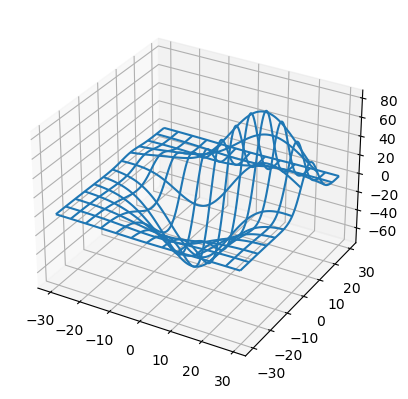

In [31]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
# fig.canvas.toolbar.button_style = 'success'

ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
# make the plot interacttaive with canvas

# fig.canvas.layout.max_width = '1000px'

plt.show()